<a href="https://colab.research.google.com/github/OskarKrafft/Machine-Learning-Project/blob/main/notebooks/06_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mounting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/Machine-Learning-Project

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Machine-Learning-Project


In [30]:
# Change working directory to project folder
%cd /content/drive/MyDrive/Colab Notebooks/Machine-Learning-Project

/content/drive/MyDrive/Colab Notebooks/Machine-Learning-Project


## Import Test Data

In [3]:
# Importing the data
import pandas as pd
eppes_cleaned = pd.read_csv('./data/processed/eppes_cleaned.csv')
eppes_cleaned = eppes_cleaned.drop(eppes_cleaned.columns[0], axis = 1)

# Import Excel sheet containing column indeces to be dropped
columns_analysis = pd.read_excel('./data/interim/Drop_Columns_categorical.xlsx')
columns_analysis = columns_analysis.drop(columns_analysis.columns[[0]], axis = 1)

# Create list of names of categorical columns 
col_names_categorical = []
for i in range(872):
  if columns_analysis.iloc[i, 3] == 'categorical':
    col_names_categorical.append(columns_analysis.iloc[i, 1])

# Change datatype of categorical variables to object
eppes_cleaned[col_names_categorical] = eppes_cleaned[col_names_categorical].astype('object')

# Define X and y
print(eppes_cleaned.head())
X = eppes_cleaned.drop(columns='qg1') # reference variable which contains voted y/n
y = eppes_cleaned['qg1'] # reference variable which contains voted y/n

# 80/20 train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state=123)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)

y_test_df = pd.DataFrame(data=y_test)
y_test_df.value_counts(normalize=True)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

y_train_df = pd.DataFrame(data=y_train)
y_train_df.value_counts(normalize=True)

# Setting up pre-processing pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Identify all categorical variables by data type
categorical_X_features = X_test.select_dtypes(include=['object', 'bool']).columns

# OneHotEncode all categorical variables
categorical_transformer = OneHotEncoder(handle_unknown="error")

preprocessor = ColumnTransformer(remainder = 'passthrough', # remainder = passthrough for numerical variables to be kept unchanged
    transformers=[
        ("cat", categorical_transformer, categorical_X_features)]
)
# Inspect the number of variables after pre-processing

# Fit the pipeline to the testing data
preprocessor.fit(X_test)
X_test_ = preprocessor.transform(X_test)

# Fit the pipeline to the training data
preprocessor.fit(X_train)
X_train_ = preprocessor.transform(X_train)

   q1.1  q1.2  q1.3  q1.4  q1.5  q1.6  q1.7  q1.8  q1.9  q1.10  ...  d43a  \
0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  ...   2.0   
1   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0    0.0  ...   2.0   
2   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  ...   2.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  ...   1.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0    0.0  ...   2.0   

   d43b  d46.8  d60  d62_1  d62_2  d63  d72_1  d72_2  d77  
0   1.0    1.0  1.0    3.0    6.0  1.0    3.0    3.0  2.0  
1   1.0    1.0  3.0    2.0    6.0  3.0    2.0    2.0  3.0  
2   2.0    1.0  1.0    1.0    5.0  2.0    2.0    2.0  1.0  
3   1.0    1.0  2.0    1.0    1.0  3.0    2.0    2.0  1.0  
4   1.0    1.0  1.0    1.0    5.0  2.0    2.0    2.0  3.0  

[5 rows x 311 columns]


Import Models

In [4]:
from sklearn.ensemble import RandomForestClassifier

best_rf = RandomForestClassifier(max_depth = 30, n_estimators = 300, min_samples_split = 5, min_samples_leaf = 1, max_features = "sqrt", random_state = 123)

In [5]:
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5,
                       n_estimators=300, random_state=123)

In [6]:
y_pred_rf = best_rf.predict(X_test)

In [7]:
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score, precision_score, recall_score
mcc = []
f1 = []

mcc.append((matthews_corrcoef(y_test, y_pred_rf)))
f1.append((f1_score(y_test, y_pred_rf)))

In [8]:
f1

[0.8014513202983271]

In [11]:
 # !pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 7.6 MB/s 


In [39]:
shap_values

.values =
array([[[ 8.79976382e-05, -8.79976382e-05],
        [-4.74248597e-05,  4.74248597e-05],
        [ 1.12687306e-04, -1.12687306e-04],
        ...,
        [-4.32049866e-04,  4.32049866e-04],
        [ 1.35804007e-04, -1.35804007e-04],
        [-2.36490820e-04,  2.36490820e-04]],

       [[-1.42712944e-04,  1.42712944e-04],
        [-3.48694625e-05,  3.48694625e-05],
        [-1.69479101e-03,  1.69479101e-03],
        ...,
        [ 1.40735357e-04, -1.40735357e-04],
        [ 4.53887390e-04, -4.53887390e-04],
        [ 1.26860617e-05, -1.26860617e-05]],

       [[ 1.80315424e-03, -1.80315424e-03],
        [ 5.88295990e-04, -5.88295990e-04],
        [ 2.29729863e-04, -2.29729863e-04],
        ...,
        [ 1.37638011e-04, -1.37638011e-04],
        [ 2.94496013e-04, -2.94496013e-04],
        [ 8.78814619e-05, -8.78814619e-05]],

       ...,

       [[-1.17448360e-04,  1.17448360e-04],
        [ 4.55220529e-05, -4.55220529e-05],
        [ 2.22198461e-04, -2.22198461e-04],
        

In [9]:
import numpy
X_train = numpy.array(X_train,dtype='float64')

In [12]:
import shap

In [13]:
explainer = shap.Explainer(best_rf, X_train)
shap_test = explainer(X_test)
print(f"Shap values length: {len(shap_test)}\n")
print(f"Sample shap value:\n{shap_test[0]}")

100%|===================| 10985/10986 [71:58<00:00]       

Shap values length: 5493

Sample shap value:
.values =
array([[-2.62031082e-03,  2.62031089e-03],
       [-1.61830647e-04,  1.61830651e-04],
       [-1.86710616e-05,  1.86710647e-05],
       [-7.30028429e-04,  7.30028435e-04],
       [-1.43717596e-04,  1.43717595e-04],
       [ 6.62219036e-05, -6.62219029e-05],
       [-2.30654673e-04,  2.30654678e-04],
       [-4.63562990e-05,  4.63563019e-05],
       [-8.98138765e-05,  8.98138814e-05],
       [ 9.80830519e-06, -9.80830514e-06],
       [ 3.43086665e-04, -3.43086657e-04],
       [-9.68328450e-06,  9.68328411e-06],
       [-8.91782041e-05,  8.91782080e-05],
       [-2.73842673e-04,  2.73842686e-04],
       [ 1.67295606e-04, -1.67295604e-04],
       [-6.49933109e-05,  6.49933119e-05],
       [ 2.12106278e-04, -2.12106280e-04],
       [-7.06551534e-05,  7.06551546e-05],
       [-4.95103641e-05,  4.95103653e-05],
       [ 1.07113515e-04, -1.07113513e-04],
       [-6.57621886e-04,  6.57621898e-04],
       [-1.46723208e-04,  1.46723206e-04],

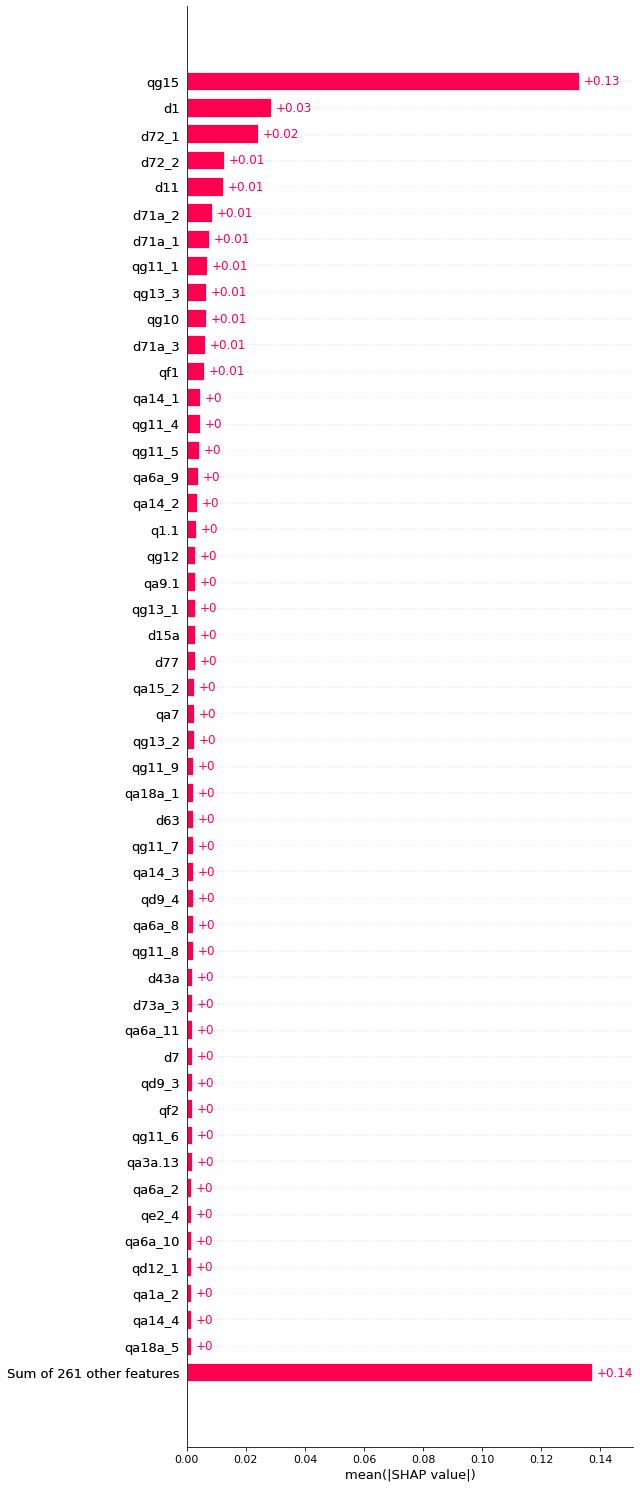

In [56]:
import matplotlib.pyplot as plt

shap_global_50 = shap.plots.bar(shap_test[:, :, 1], max_display=50, show=False)
plt.savefig('shap_global_50.png', bbox_inches="tight", dpi = 144)

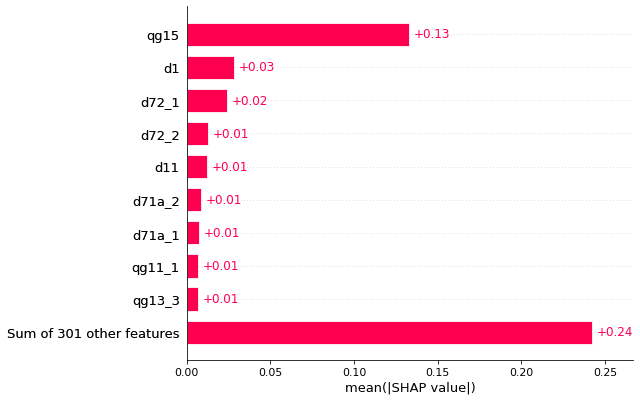

In [57]:
shap_global_10 = shap.plots.bar(shap_test[:, :, 1], max_display=10, show=False)

plt.savefig('shap_global_10.png', bbox_inches="tight", dpi = 144)

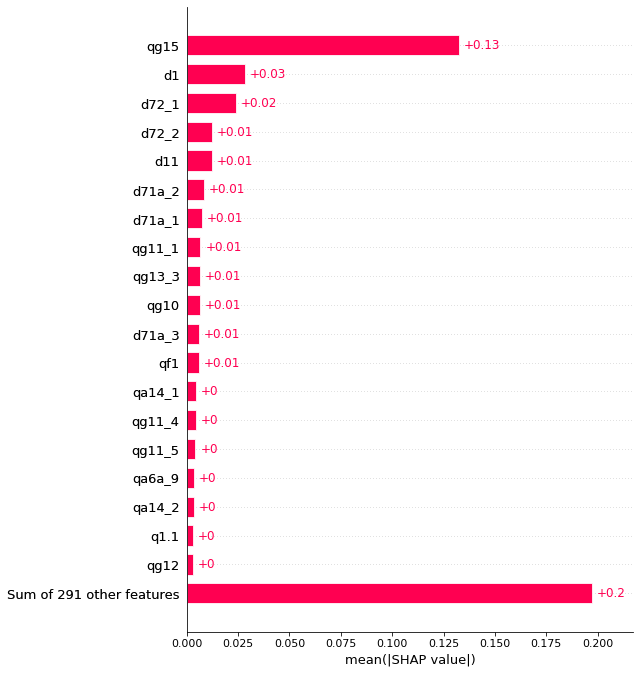

In [58]:
shap_global_20 = shap.plots.bar(shap_test[:, :, 1], max_display=20, show=False)
plt.savefig('shap_global_20.png', bbox_inches="tight", dpi = 144)

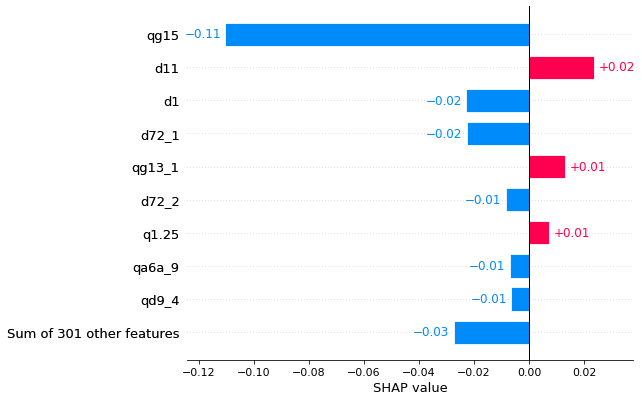

In [59]:
shap_local_10 = shap.plots.bar(shap_test[:, :, 1][421], max_display=10, show=False)
plt.savefig('shap_local_10.png', bbox_inches="tight", dpi = 144)

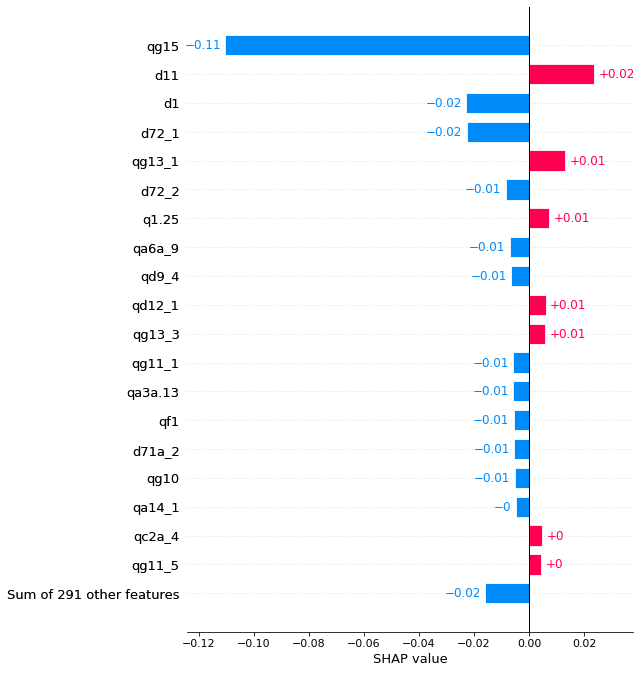

In [60]:
shap_local_20 = shap.plots.bar(shap_test[:, :, 1][421], max_display=20, show=False)
plt.savefig('shap_local_20.png', bbox_inches="tight", dpi = 144)